In [1]:
import glob
import os

In [2]:
def findFiles(path):return glob.glob(path)

PATH = "data_rnn/data/names/"
#print(findFiles(f"{PATH}/*.txt"))
print(findFiles(PATH+"*.txt"))

In [3]:
#open(f"{PATH}/Arabic.txt").read().strip().split("\n")[:10]
open(PATH+"Arabic.txt").read().strip().split("\n")[:5]

In [4]:
import string
import unicodedata

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
print(n_letters)

In [5]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != 'Mn')
print(unicodeToAscii('Ślusàrski'))

In [6]:
category_lines = {}
all_categories = []

def readNames(filename):
    lines = open(filename, "r", encoding= 'utf-8').read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

#for file in findFiles(f"{PATH}/*.TXT"):
for file in findFiles(PATH+"*.txt"):
    language = os.path.splitext(os.path.basename(file))[0]
    category_lines[language] = readNames(file)
    all_categories.append(language)
    
n_categories = len(all_categories)

In [7]:
#find number of languages, and names
for k,v in category_lines.items():
    print("{} has {} names".format(k, len(v)))

In [8]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

letterToTensor('J')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [9]:
def lineToTensor(line):
    one_hot_encode = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        one_hot_encode[idx][0][letterToIndex(letter)] = 1
    return one_hot_encode

lineToTensor("xiao").size()

torch.Size([4, 1, 56])

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor("A")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [12]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8178, -2.7996, -2.8778, -2.9398, -2.8011, -2.9174, -2.8639, -3.0229,
         -2.8980, -2.9381, -2.8970, -2.9194, -2.9976, -2.9531, -2.8463, -2.8711,
         -2.8958, -2.8054]], grad_fn=<LogSoftmaxBackward>)

In [13]:
def categoryFromOutput(output):
    #top_n is the logprobability, and top_i is the index
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('Chinese', 1)

In [14]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Schultheis
category = Japanese / line = Tsutaya
category = Japanese / line = Nanami
category = Polish / line = Janda
category = Dutch / line = Rompaij
category = Spanish / line = Durante
category = Chinese / line = Thien
category = Irish / line = Sloan
category = English / line = Helm
category = Greek / line = Kosmas


In [15]:
import torch.optim as optim

learning_rate = 5e-3
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward(retain_graph = True)
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

In [16]:
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print("{} {}% loss: {:.3f}, {} --> {} {}".format(iter, iter/n_iters*100, loss, line, guess, correct))
    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5.0% loss: 2.629, Miazga --> Japanese ✗ (Polish)
10000 10.0% loss: 3.102, Tadhg --> Arabic ✗ (Irish)
15000 15.0% loss: 1.253, Lu: --> Korean ✗ (Chinese)
20000 20.0% loss: 1.667, Mcmillan --> Irish ✗ (Scottish)
25000 25.0% loss: 1.995, Kate --> Korean ✗ (Japanese)
30000 30.0% loss: 1.302, Ahn --> Vietnamese ✗ (Korean)
35000 35.0% loss: 2.075, Voclain --> Irish ✗ (French)
40000 40.0% loss: 2.353, Koci --> Italian ✗ (Czech)
45000 45.0% loss: 2.088, Houtum --> Polish ✗ (Dutch)
50000 50.0% loss: 2.642, Magee --> French ✗ (English)
55000 55.00000000000001% loss: 0.589, To --> Vietnamese ✓
60000 60.0% loss: 3.482, Jenkinson --> Scottish ✗ (English)
65000 65.0% loss: 1.182, Crawford --> English ✗ (Scottish)
70000 70.0% loss: 1.095, Episcopo --> Italian ✓
75000 75.0% loss: 0.758, Stevenson --> Scottish ✓
80000 80.0% loss: 0.355, Halabi --> Arabic ✓
85000 85.0% loss: 0.267, Najjar --> Arabic ✓
90000 90.0% loss: 0.231, Ferrari --> Italian ✓
95000 95.0% loss: 1.699, Simpson --> Scottish ✗ (En

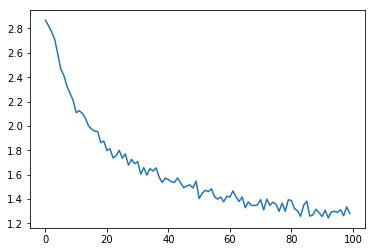

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.plot(all_losses)

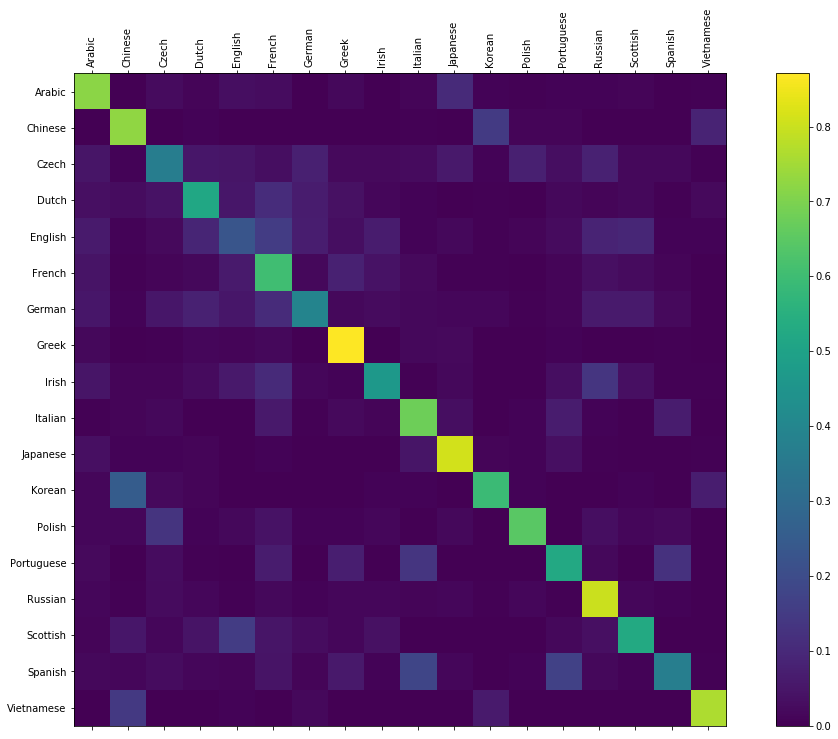

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
def predict(input_line, n_predictions = 3):
    print("\n > {}".format(input_line))
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("{:.2f} {}".format(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [20]:
predict("Xiao")
predict("Jackson")
predict("Satoshi")


 > Xiao
-0.17 Chinese
-2.86 Portuguese
-3.22 Vietnamese

 > Jackson
-0.95 English
-1.65 Scottish
-1.77 Russian

 > Satoshi
-1.23 Japanese
-1.56 Italian
-2.27 Portuguese
